## Learning Vector Quantization example with the Iris and other datasets

Learning Vector Quantization (LVQ) classifier like the k-Nearest Neighbors classifier is prone to suffer from sparse data, from irrelevant attributes, and from scaling-related problems. 

This notebook provides examples of LVQ usage in combination with tools and other classifiers in scikit-learn, in particular:
- loop over multiple classifiers 
- hyper-parameter grid search and cross-validation: model_selection.GridSearchCV 
- hyper-parameter randomized search: model_selection.RandomizedSearchCV
- calibration : sklearn.calibration.CalibratedClassifierCV
- voting: ensemble.VotingClassifier
- pipeline: pipeline.Pipeline

Real datasets have been used to test the LVQ routines:
- digit dataset

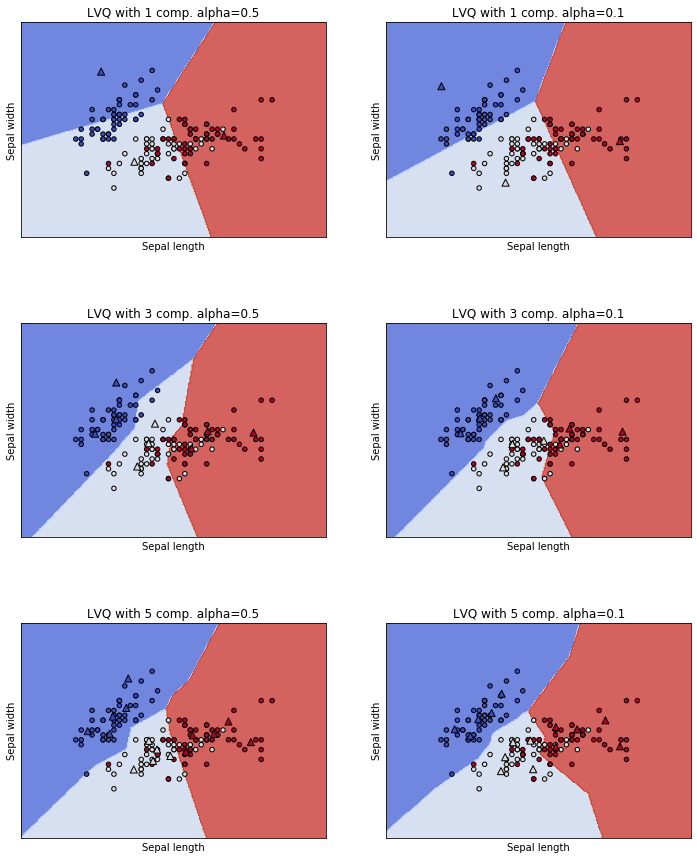

In [2]:
#print(__doc__)
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from LVQClassifier import LVQClassifier as LVQ

def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in
    
    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional
    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.
    
    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional 
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

# import some data to play with
iris = datasets.load_iris()
# Take the first two features. We could avoid this by using a 
# two-dim dataset 
X = iris.data[:, :2]
y = iris.target

# LVQ parameter
epochs = 10
LVQ2 = False
models = (LVQ(n_components=1,alpha=0.5,epochs=epochs,LVQ2=LVQ2),
          LVQ(n_components=1,alpha=0.1,epochs=epochs,LVQ2=LVQ2),
          LVQ(n_components=3,alpha=0.5,epochs=epochs,LVQ2=LVQ2),
          LVQ(n_components=3,alpha=0.1,epochs=epochs,LVQ2=LVQ2),
          LVQ(n_components=5,alpha=0.5,epochs=epochs,LVQ2=LVQ2),
          LVQ(n_components=5,alpha=0.1,epochs=epochs,LVQ2=LVQ2))

models = (clf.fit(X, y) for clf in models) # sklearn loop over the models

# title for the plots
titles = ('LVQ with 1 comp. alpha=0.5',
          'LVQ with 1 comp. alpha=0.1',
          'LVQ with 3 comp. alpha=0.5',
          'LVQ with 3 comp. alpha=0.1',
          'LVQ with 5 comp. alpha=0.5',
          'LVQ with 5 comp. alpha=0.1')

fig, sub = plt.subplots(3, 2, figsize=(12,15))
plt.subplots_adjust(wspace=0.2, hspace=0.4)

X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)

for clf, title, ax in zip(models, titles, sub.flatten()): 
    X_LVQ = clf.weights
    y_LVQ = clf.label_weights 
    plot_contours(ax, clf, xx, yy,
                  cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.scatter(X_LVQ[:, 0], X_LVQ[:, 1], c=y_LVQ,
               cmap=plt.cm.coolwarm, s=50, marker='^', edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('Sepal length')
    ax.set_ylabel('Sepal width')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)
plt.show()

### Imbalanced datset

/Library/Python/2.7/site-packages/matplotlib/contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


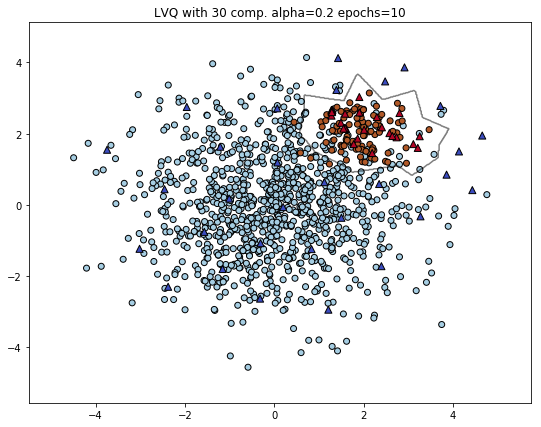

In [2]:
#print(__doc__)

from LVQClassifier import LVQClassifier as LVQ
# we create clusters with 1000 and 100 points
rng = np.random.RandomState(0)
n_samples_1 = 1000
n_samples_2 = 100
X = np.r_[1.5 * rng.randn(n_samples_1, 2),
          0.5 * rng.randn(n_samples_2, 2) + [2, 2]]
y = [0] * (n_samples_1) + [1] * (n_samples_2)

# LVQ parameter
epochs = 10
# LVQ1, no bias correction, uniform random initial state
clf = LVQ(n_components=30,alpha=0.1,epochs=epochs,
          initial_state='Uniform',bias_decrease_rate=1.0)
clf.fit(X, y)
X_LVQ = clf.weights
y_LVQ = clf.label_weights
title = 'LVQ with 30 comp. alpha=0.2 epochs=10'

plt.figure(figsize=(9, 7))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, edgecolors='k')
plt.scatter(X_LVQ[:, 0], X_LVQ[:, 1], c=y_LVQ,
               cmap=plt.cm.coolwarm, s=50, marker='^', edgecolors='k')
plt.title(title)

# create grid to evaluate model
X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contour(xx, yy, Z,  colors='k', levels=[0], alpha=0.5, 
               linestyles=['-'])
plt.show()

### Classifier Calibration

Precision = Efficiency = 1 - contamination = TP/(TP+FP)
Recall = Completeness = TP/(TP+FN)

Logistic:
	Brier: 0.099
	Precision (Efficiency): 0.872
	Recall (Completeness): 0.851
	F1: 0.862

LVQ:
	Brier: 0.172
	Precision (Efficiency): 0.948
	Recall (Completeness): 0.643
	F1: 0.766

LVQ + Isotonic:
	Brier: 0.102
	Precision (Efficiency): 0.880
	Recall (Completeness): 0.839
	F1: 0.859

LVQ + Sigmoid:
	Brier: 0.101
	Precision (Efficiency): 0.881
	Recall (Completeness): 0.840
	F1: 0.860



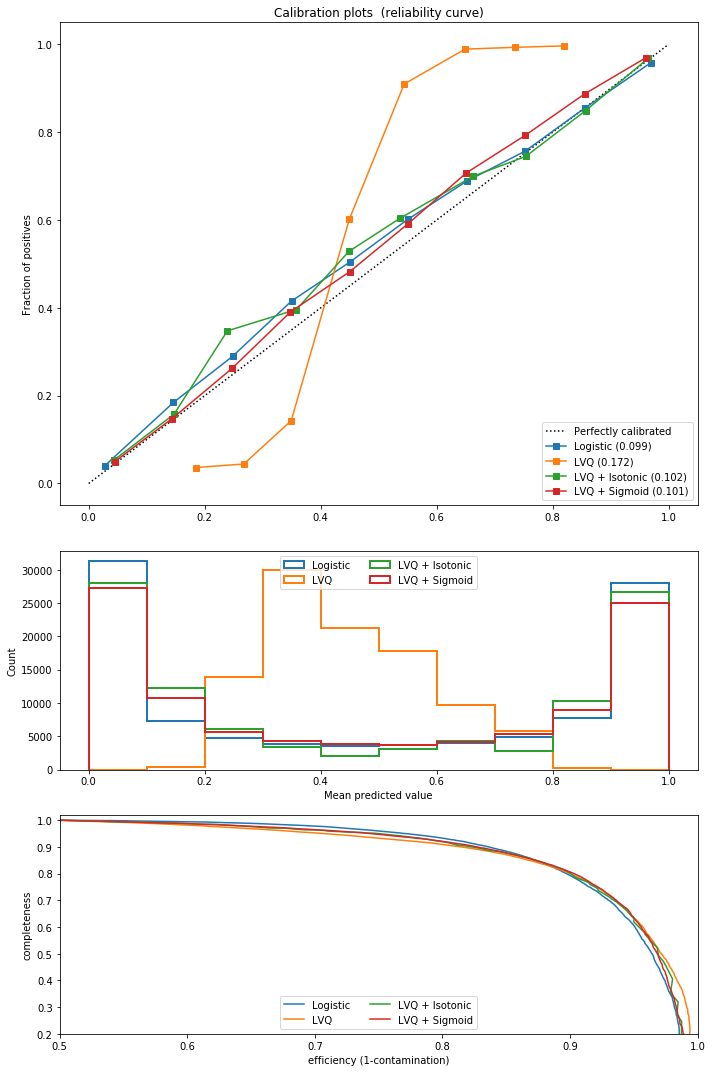

In [3]:
# print(__doc__)
# Author: Alexandre Gramfort <alexandre.gramfort@telecom-paristech.fr>
#         Jan Hendrik Metzen <jhm@informatik.uni-bremen.de>
# Author: Wing-Fai Thi modified to calibrate LVQ
# License: BSD Style.

import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (brier_score_loss, precision_score, 
                             recall_score, f1_score)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.model_selection import train_test_split
# extra packages
from astroML.utils import completeness_contamination
from LVQClassifier import LVQClassifier as LVQ

# Create dataset of classification task with many redundant and few 
# informative features
X, y = datasets.make_classification(n_samples=100000, n_features=20,
                                    n_informative=2, n_redundant=10,
                                    random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.99,
                                                    random_state=42)

def plot_calibration_curve(est, name, fig_index):
    """Plot calibration curve for est w/o and with calibration. """
    
    # Calibrated with isotonic calibration
    isotonic = CalibratedClassifierCV(est, cv=2, method='isotonic') 
    
    # Calibrated with sigmoid calibration
    sigmoid = CalibratedClassifierCV(est, cv=2, method='sigmoid')
    
    # Logistic regression with no calibration as baseline
    lr = LogisticRegression(C=1., solver='lbfgs')
    
    fig = plt.figure(fig_index, figsize=(10, 15))
    ax1 = plt.subplot2grid((4, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((4, 1), (2, 0))
    ax3 = plt.subplot2grid((4, 1), (3, 0))
    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    
    # Precision : what % of positive predictions were correct?
    print "Precision = Efficiency = 1 - contamination = TP/(TP+FP)"
    # Recall (completeness) what % of positive cases did model catch?
    print "Recall = Completeness = TP/(TP+FN)"
    print
    thresholds = np.linspace(0, 1, 1001)[:-1]
    for clf, name in [(lr, 'Logistic'),
                      (est, name),
                      (isotonic, name + ' + Isotonic'),
                      (sigmoid, name + ' + Sigmoid')]:
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        y_prob = clf.predict_proba(X_test)
        if hasattr(clf, "predict_proba"):
            prob_pos = clf.predict_proba(X_test)[:, 1] 
        else: # use decision function
            prob_pos = clf.decision_function(X_test)
            prob_pos = \
                (prob_pos - prob_pos.min()) / (prob_pos.max() - 
                                               prob_pos.min())

        clf_score = brier_score_loss(y_test, prob_pos, pos_label=y.max()) 
        print("%s:" % name)
        print("\tBrier: %1.3f" % (clf_score))
        print("\tPrecision (Efficiency): %1.3f" % precision_score(y_test, y_pred)) 
        print("\tRecall (Completeness): %1.3f" % recall_score(y_test, y_pred)) 
        print("\tF1: %1.3f\n" % f1_score(y_test, y_pred))

        fraction_of_positives, mean_predicted_value = \
            calibration_curve(y_test, prob_pos, n_bins=10)
        ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label="%s (%1.3f)" % (name, clf_score))
        ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
                 histtype="step", lw=2)
        
        comp = np.zeros_like(thresholds)
        cont = np.zeros_like(thresholds)
        for i, t in enumerate(thresholds):
            pred = (y_prob >= t)[:,1]
            comp[i], cont[i] = completeness_contamination(pred, y_test)
        ax3.plot(1 - cont, comp, label=name)
        
    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)')
    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper center", ncol=2)
    ax3.set_xlabel('efficiency (1-contamination)')
    ax3.set_ylabel('completeness')
    ax3.legend(loc="lower center", ncol=2)
    ax3.set_xlim(0.5, 1.0)
    ax3.set_ylim(0.2, 1.02)

    plt.tight_layout()
    
# Plot calibration curve for Linear Vector Quantization
plot_calibration_curve(LVQ(), "LVQ", 1) 
plt.show()

LVQ probabilities are gathered around 0.5 and thus show a sigmoid form in the calibraiton plot like SVM, typical for an under-confident classifier.. A calibration with a sigmoid or an isotonic function gives the best correction.

The calibration performance is evaluated with Brier score brier_score_loss, reported in the legend (the smaller the better).

First a few helper functions from Andreas Mueller

In [4]:
# mglearn
# Author Andreas Mueller
from sklearn.datasets import make_blobs
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import colorConverter, LinearSegmentedColormap


cm_cycle = ListedColormap(['#0000aa', '#ff5050', '#50ff50', '#9040a0',
                           '#fff000'])
cm3 = ListedColormap(['#0000aa', '#ff2020', '#50ff50'])
cm2 = ListedColormap(['#0000aa', '#ff2020'])

# create a smooth transition from the first to to the second color of cm3
# similar to RdBu but with our red and blue, also not going through white,
# which is really bad for greyscale

cdict = {'red': [(0.0, 0.0, cm2(0)[0]),
                 (1.0, cm2(1)[0], 1.0)],

         'green': [(0.0, 0.0, cm2(0)[1]),
                   (1.0, cm2(1)[1], 1.0)],

         'blue': [(0.0, 0.0, cm2(0)[2]),
                  (1.0, cm2(1)[2], 1.0)]}

ReBl = LinearSegmentedColormap("ReBl", cdict)

def discrete_scatter(x1, x2, y=None, markers=None, s=10, ax=None,
                     labels=None, padding=.2, alpha=1, c=None,
                     markeredgewidth=None):
    """Adaption of matplotlib.pyplot.scatter to plot classes or clusters.

    Parameters
    ----------

    x1 : nd-array
        input data, first axis

    x2 : nd-array
        input data, second axis

    y : nd-array
        input data, discrete labels

    cmap : colormap
        Colormap to use.

    markers : list of string
        List of markers to use, or None (which defaults to 'o').

    s : int or float
        Size of the marker

    padding : float
        Fraction of the dataset range to use for padding the axes.

    alpha : float
        Alpha value for all points.
    """
    if ax is None:
        ax = plt.gca()

    if y is None:
        y = np.zeros(len(x1))

    unique_y = np.unique(y)

    if markers is None:
        markers = ['o', '^', 'v', 'D', 's', '*', 'p', 'h', 'H', 
                   '8', '<', '>'] * 10

    if len(markers) == 1:
        markers = markers * len(unique_y)

    if labels is None:
        labels = unique_y

    # lines in the matplotlib sense, not actual lines
    lines = []

    current_cycler = mpl.rcParams['axes.prop_cycle']

    for i, (yy, cycle) in enumerate(zip(unique_y, current_cycler())):
        mask = y == yy
        # if c is none, use color cycle
        if c is None:
            color = cycle['color']
        elif len(c) > 1:
            color = c[i]
        else:
            color = c
        # use light edge for dark markers
        if np.mean(colorConverter.to_rgb(color)) < .4:
            markeredgecolor = "grey"
        else:
            markeredgecolor = "black"

        lines.append(ax.plot(x1[mask], x2[mask], markers[i], markersize=s,
                             label=labels[i], alpha=alpha, c=color,
                             markeredgewidth=markeredgewidth,
                             markeredgecolor=markeredgecolor)[0])

    if padding != 0:
        pad1 = x1.std() * padding
        pad2 = x2.std() * padding
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        ax.set_xlim(min(x1.min() - pad1, xlim[0]), 
                    max(x1.max() + pad1, xlim[1]))
        ax.set_ylim(min(x2.min() - pad2, ylim[0]), 
                    max(x2.max() + pad2, ylim[1]))

    return lines

def make_forge():
    # a carefully hand-designed dataset lol
    X, y = make_blobs(centers=2, random_state=4, n_samples=30)
    y[np.array([7, 27])] = 0
    mask = np.ones(len(X), dtype=np.bool)
    mask[np.array([0, 1, 5, 26])] = 0
    X, y = X[mask], y[mask]
    return X, y

def plot_knn_classification(n_neighbors=1):
    X, y = make_forge()

    X_test = np.array([[8.2, 3.66214339], [9.9, 3.2], [11.2, .5]])
    dist = euclidean_distances(X, X_test)
    closest = np.argsort(dist, axis=0)

    for x, neighbors in zip(X_test, closest.T):
        for neighbor in neighbors[:n_neighbors]:
            plt.arrow(x[0], x[1], X[neighbor, 0] - x[0],
                      X[neighbor, 1] - x[1], head_width=0, fc='k', ec='k')

    clf = KNeighborsClassifier(n_neighbors=n_neighbors).fit(X, y)
    test_points = discrete_scatter(X_test[:, 0], X_test[:, 1], 
                                   clf.predict(X_test), markers="*")
    training_points = discrete_scatter(X[:, 0], X[:, 1], y)
    plt.legend(training_points + test_points,
               ["training class 0", "training class 1",
                        "test pred 0", "test pred 1"])


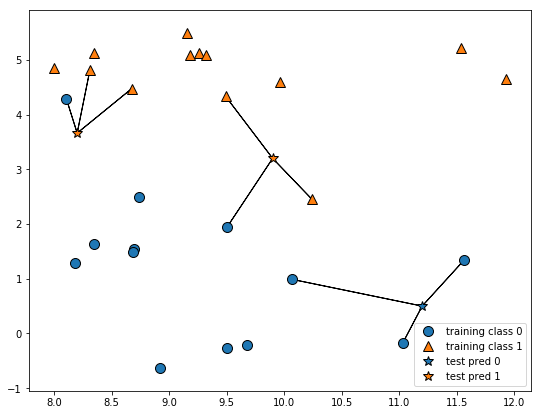

In [5]:
# Author Andreas Mueller
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import euclidean_distances
from sklearn.neighbors import KNeighborsClassifier

def plot_knn_classification(n_neighbors=1):
    X, y = make_forge()

    X_test = np.array([[8.2, 3.66214339], [9.9, 3.2], [11.2, .5]])
    dist = euclidean_distances(X, X_test)
    closest = np.argsort(dist, axis=0)

    plt.figure(figsize=(9,7))
    for x, neighbors in zip(X_test, closest.T):
        for neighbor in neighbors[:n_neighbors]:
            plt.arrow(x[0], x[1], X[neighbor, 0] - x[0],
                      X[neighbor, 1] - x[1], head_width=0, fc='k', ec='k')

    clf = KNeighborsClassifier(n_neighbors=n_neighbors).fit(X, y)
    test_points = discrete_scatter(X_test[:, 0], X_test[:, 1],
                                   clf.predict(X_test), markers="*")
    training_points = discrete_scatter(X[:, 0], X[:, 1], y)
    plt.legend(training_points + test_points, 
               ["training class 0", "training class 1",
                "test pred 0", "test pred 1"])
plot_knn_classification(n_neighbors=3)


Show the difference in behavior between the kNN and LVQ method. 
The LVQ prototypes are shown.



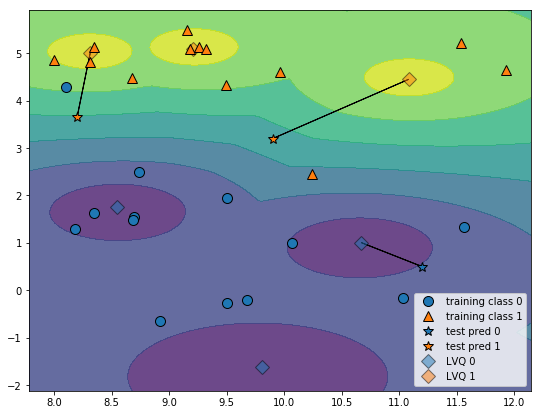

In [6]:
# modified from plot_knn_classification
"""
Show the difference in behavior between the kNN and LVQ method. 
The LVQ prototypes are shown.
"""
print(__doc__)
def plot_lvq_classification(n_components=1):
    X, y = make_forge()

    X_test = np.array([[8.2, 3.66214339], [9.9, 3.2], [11.2, .5]])

    clf = LVQ(n_components=n_components,alpha=0.5,epochs=5,
              initial_state='Normal').fit(X, y)
    X_LVQ = clf.weights
    y_LVQ = clf.label_weights
    dist = euclidean_distances(X_LVQ, X_test)
    closest = np.argsort(dist, axis=0)
    plt.figure(figsize=(9,7))
    LVQ_points = discrete_scatter(X_LVQ[:, 0], 
                                  X_LVQ[:, 1], y_LVQ, alpha=0.5,
                                  markers="D")
    test_points = discrete_scatter(X_test[:, 0], X_test[:, 1], 
                                   clf.predict(X_test), alpha=1,
                                   markers="*")
    for x, neighbor in zip(X_test, closest.T):
        plt.arrow(x[0], x[1], X_LVQ[neighbor[0], 0] - x[0],
                      X_LVQ[neighbor[0], 1] - x[1], 
                      head_width=0, fc='k', ec='k')

    training_points = discrete_scatter(X[:, 0], X[:, 1], y,
                                       alpha=1.0, s=10)

    h = .05  # step size in the mesh
    x_min, x_max = X[:, 0].min()-2., X[:, 0].max()+1.
    y_min, y_max = X[:, 1].min()-2., X[:, 1].max()+1.
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=.8)
    
    plt.legend(training_points + test_points + LVQ_points,
               ["training class 0", "training class 1",
                "test pred 0", "test pred 1",
                "LVQ 0","LVQ 1"])

plot_lvq_classification(n_components=3)

### LVQ as part of a Voting scheme

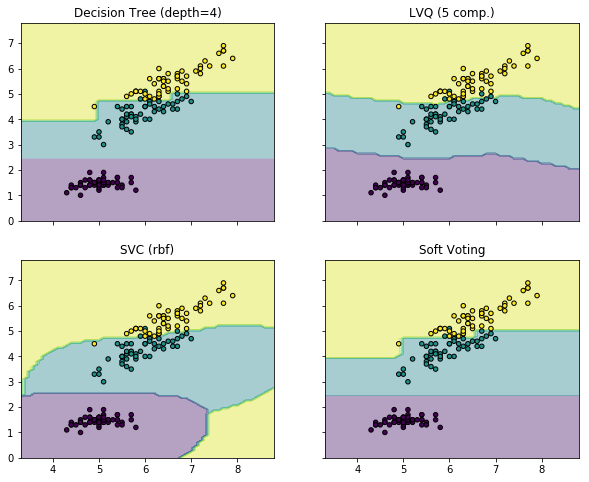

In [7]:
# original version from sklearn user guide 0.19.1
# Here LVQ is replacing KNN
#print(__doc__)
from itertools import product
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from LVQClassifier import LVQClassifier as LVQ

# Loading some example data
iris = datasets.load_iris()
X = iris.data[:, [0, 2]]
y = iris.target

# Training classifiers
clf1 = DecisionTreeClassifier(max_depth=4)
clf2 = LVQ(n_components=5)
clf3 = SVC(kernel='rbf', probability=True)

eclf = VotingClassifier(estimators=[('dt', clf1), ('lvq', clf2),
                                    ('svc', clf3)],
                        voting='soft', weights=[2, 1, 2])
clf1.fit(X, y)
clf2.fit(X, y)
clf3.fit(X, y)
eclf.fit(X, y)
            
# Plotting decision regions
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
f, axarr = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(10, 8))
for idx, clf, tt in zip(product([0, 1], [0, 1]), [clf1, clf2, clf3, eclf],
                        ['Decision Tree (depth=4)','LVQ (5 comp.)', 
                         'SVC (rbf)', 'Soft Voting']):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx[0], idx[1]].scatter(X[:, 0], X[:, 1], c=y,
                                  s=20, edgecolor='k')
    axarr[idx[0], idx[1]].set_title(tt)
plt.show()


Classifier comparison

A comparison of a several classifiers in scikit-learn on synthetic 
datasets. The point of this example is to illustrate the nature of 
decision boundaries of different classifiers.
This should be taken with a grain of salt, as the intuition conveyed by
these examples does not necessarily carry over to real datasets.

Particularly in high-dimensional spaces, data can more easily be separated
linearly and the simplicity of classifiers such as naive Bayes and linear
SVMs might lead to better generalization than is achieved by other 
classifiers.

The plots show training points in solid colors and testing points
semi-transparent. The lower right shows the classification accuracy on 
the test set.



/Library/Python/2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


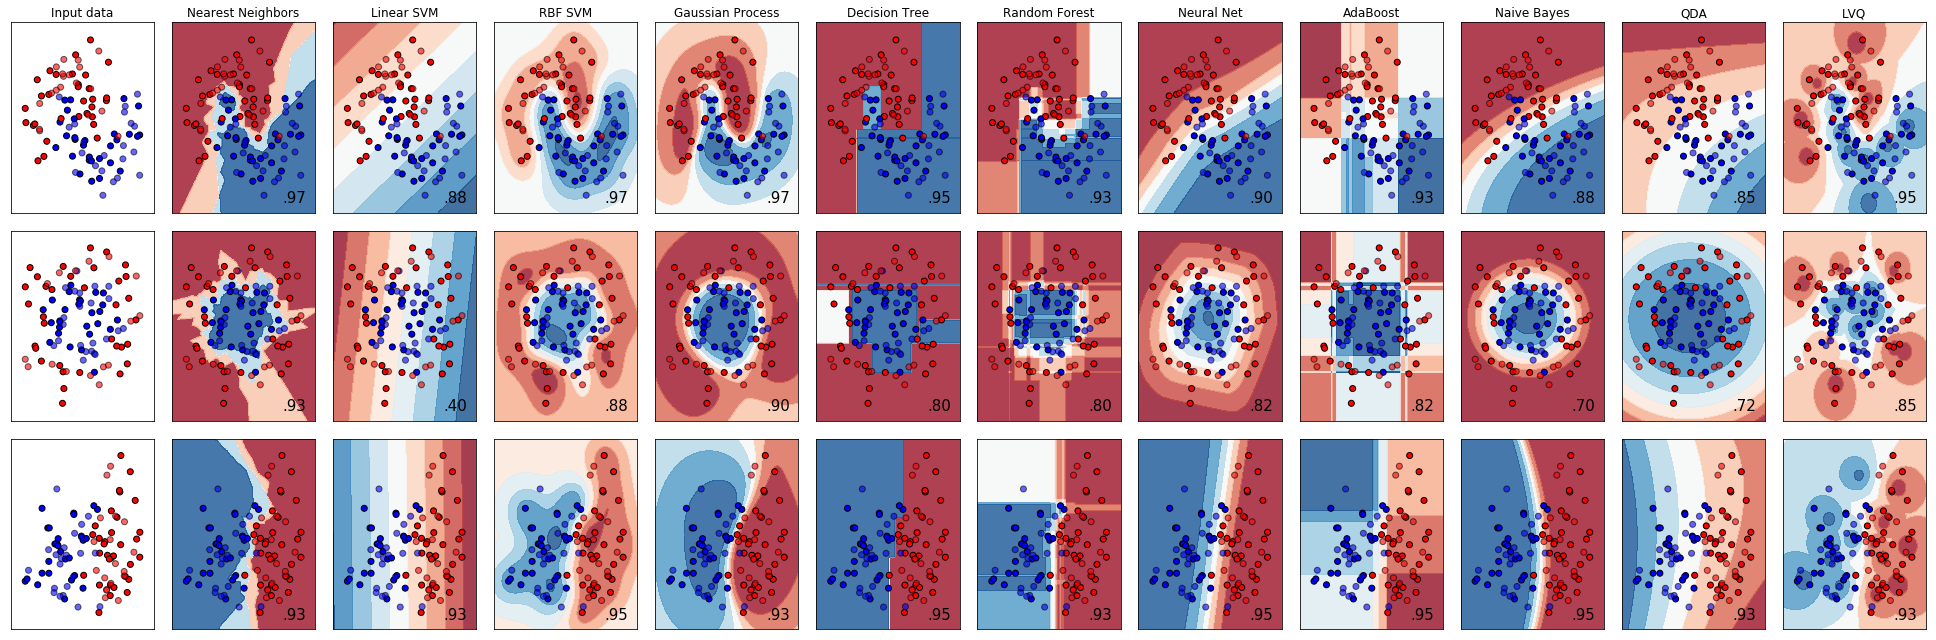

In [8]:
#!/usr/bin/python
# -*- coding: utf-8 -*-

"""
=====================
Classifier comparison
=====================

A comparison of a several classifiers in scikit-learn on synthetic 
datasets. The point of this example is to illustrate the nature of 
decision boundaries of different classifiers.
This should be taken with a grain of salt, as the intuition conveyed by
these examples does not necessarily carry over to real datasets.

Particularly in high-dimensional spaces, data can more easily be separated
linearly and the simplicity of classifiers such as naive Bayes and linear
SVMs might lead to better generalization than is achieved by other 
classifiers.

The plots show training points in solid colors and testing points
semi-transparent. The lower right shows the classification accuracy on 
the test set.
"""
print(__doc__)


# Code source: Gaël Varoquaux
#              Andreas Müller
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from LVQClassifier import LVQClassifier as LVQ

h = .02  # step size in the mesh

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA","LVQ"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1,max_iter=200),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
    LVQ(n_components=7,epochs=10)] # 2 classes -> odd n_components

X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [make_moons(noise=0.3, random_state=0),
            make_circles(noise=0.2, factor=0.5, random_state=1),
            linearly_separable
            ]

figure = plt.figure(figsize=(27, 9))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.4, random_state=42)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
               edgecolors='k')
    # and testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, 
               alpha=0.6,
               edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

        # Plot the decision boundary. For that, we will assign a color 
        # to each point in the mesh [x_min, x_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot also the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, 
                   cmap=cm_bright,
                   edgecolors='k')
        # and testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                   edgecolors='k', alpha=0.6)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(xx.max() - .3, yy.min() + .3,
                ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')
        i += 1

plt.tight_layout()
plt.show()

#### Imbalanced dataset and complex distribution

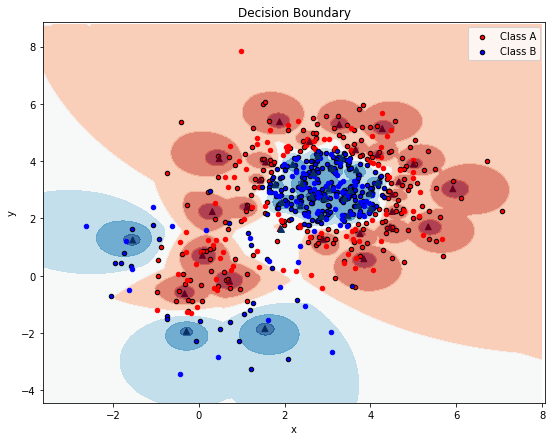

Train data
	Accuracy: 0.945
	Brier: 0.080
	Precision (Efficiency): 0.951
	Recall (Completeness): 0.946
	F1: 0.949

Test data
	Accuracy: 0.900
	Brier: 0.104
	Precision (Efficiency): 0.863
	Recall (Completeness): 0.908
	F1: 0.885



In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.datasets import make_gaussian_quantiles
# Construct dataset
# imbalanced data 100/500
X1, y1 = make_gaussian_quantiles(cov=2.,
                                 n_samples=100, n_features=2,
                                 n_classes=2, random_state=1)
X2, y2 = make_gaussian_quantiles(mean=(3, 3), cov=1.5,
                                 n_samples=500, n_features=2,
                                 n_classes=2, random_state=1)
X = np.concatenate((X1, X2))
y = np.concatenate((y1, - y2 + 1))

seed = 1
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3,
                                                    random_state=seed) 
# each class is reduced to 25 prototypes
clf = LVQ(n_components=25,epochs=10,alpha=0.5,
          initial_state='Uniform',LVQ2=True)
clf.fit(X_train,y_train)
X_LVQ = clf.weights
y_LVQ = clf.label_weights

h = .1  # step size in the mesh
plot_colors = "rb"
class_names = "AB"

cm = plt.cm.RdBu
plt.figure(figsize=(9, 7))
# Plot the decision boundaries
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=cm, alpha=.8)
plt.axis("tight")
# Plot the training points
for i, n, c in zip(range(2), class_names, plot_colors): 
    idx = np.where(y_train == i)
    plt.scatter(X_train[idx, 0], X_train[idx, 1],
        c=c, cmap=cm, s=20, 
        edgecolor='k', label="Class %s" % n)
    idx = np.where(y_test == i)
    plt.scatter(X_test[idx, 0], X_test[idx, 1],
        c=c, cmap=cm, s=20)
plt.scatter(X_LVQ[:, 0], X_LVQ[:, 1], c=y_LVQ, cmap=cm, 
            alpha=1.0,marker="^")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.legend(loc='upper right')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Decision Boundary')
plt.show()

y_prob = clf.predict_proba(X_train)[:,1]
y_pred = clf.predict(X_train)
accuracy = accuracy_score(y_train, y_pred)
brier = brier_score_loss(y_train, y_prob, pos_label=y.max())
print "Train data"
print("\tAccuracy: %1.3f" % (accuracy))
print("\tBrier: %1.3f" % (brier))
print("\tPrecision (Efficiency): %1.3f" % precision_score(y_train, y_pred)) 
print("\tRecall (Completeness): %1.3f" % recall_score(y_train, y_pred)) 
print("\tF1: %1.3f\n" % f1_score(y_train, y_pred))
#
y_prob = clf.predict_proba(X_test)[:,1]
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
brier = brier_score_loss(y_test, y_prob, pos_label=y.max())
print "Test data"
print("\tAccuracy: %1.3f" % (accuracy))
print("\tBrier: %1.3f" % (brier))
print("\tPrecision (Efficiency): %1.3f" % precision_score(y_test, y_pred)) 
print("\tRecall (Completeness): %1.3f" % recall_score(y_test, y_pred)) 
print("\tF1: %1.3f\n" % f1_score(y_test, y_pred))

LVQ creates spheres of influences.

### Grid Search and LVQ

Here we test a scikit-learn hyper-parameter fine-tunning with a grid search.

In [10]:
import pandas as pd

from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict

seed = 2017
# read the data in
df = pd.read_csv("Diabetes.csv")
X = df.iloc[:,:8].values     # independent variables
y = df['class'].values     # dependent variables
#Normalize
X = StandardScaler().fit_transform(X)
# evaluate the model by splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3,
                                                    random_state=seed) 
kfold  = StratifiedKFold(n_splits=5, random_state=seed,shuffle=True)

clf_lvq = LVQ(random_state=seed,epochs=5).fit(X_train, y_train)
rf_params = {
    'n_components': [3, 5],
    'alpha':  [0.1, 0.3]}

# setting verbose = 10 will print the progress for every 
# 10 task completion
grid = GridSearchCV(clf_lvq, rf_params, scoring='roc_auc', 
                    cv=kfold, verbose=0, n_jobs=-1)
grid.fit(X_train, y_train)
print 'Best Parameters: ', grid.best_params_
results = cross_val_score(grid.best_estimator_, 
                                X_train,y_train, cv=kfold)
print "Accuracy - Train CV: ", results.mean()
print "Accuracy - Train : ", metrics.accuracy_score(grid.best_estimator_.
predict(X_train), y_train)
print "Accuracy - Test : ", metrics.accuracy_score(grid.best_estimator_.
predict(X_test), y_test)

Best Parameters:  {'alpha': 0.3, 'n_components': 3}
Accuracy - Train CV:  0.724472135687
Accuracy - Train :  0.735567970205
Accuracy - Test :  0.774891774892


### Random search

In [11]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from sklearn.metrics import accuracy_score

# specify parameters and distributions to sample from
param_dist = {'n_components': [3, 5],
              'alpha':  [0.1, 0.3]}

# run randomized search
seed = 2001
n_iter_search = 4
random_search = RandomizedSearchCV(clf_lvq, param_distributions=param_dist, 
                                   cv=kfold,
                                   n_iter=n_iter_search, 
                                   verbose=0, n_jobs=-1, 
                                   random_state=seed)
random_search.fit(X_train, y_train)

# report(random_search.cv_results_)
print 'Best Parameters: ', random_search.best_params_
results = cross_val_score(random_search.best_estimator_,
X_train,y_train, cv=kfold)
print "Accuracy - Train CV: ", results.mean()
print "Accuracy - Train : ", accuracy_score(random_search.best_estimator_.predict(X_train), y_train)
print "Accuracy - Test : ", accuracy_score(random_search.best_estimator_.predict(X_test), y_test)

Best Parameters:  {'alpha': 0.3, 'n_components': 3}
Accuracy - Train CV:  0.724472135687
Accuracy - Train :  0.735567970205
Accuracy - Test :  0.774891774892


### Pipeline with LVQ

In [12]:
# Author: Andreas Mueller <amueller@ais.uni-bonn.de>
#
# License: BSD 3 clause
from sklearn.pipeline import Pipeline, FeatureUnion 
from sklearn.model_selection import GridSearchCV 
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.svm import SVC
iris = load_iris()
X, y = iris.data, iris.target

# This dataset is way too high-dimensional. Better do PCA:
pca = PCA(n_components=2)

# Maybe some original features where good, too?
selection = SelectKBest(k=1)

# Build estimator from PCA and Univariate selection:
combined_features = FeatureUnion([("pca", pca), 
                                  ("univ_select", selection)])

# Use combined features to transform dataset:
X_features = combined_features.fit(X, y).transform(X)
lvq = LVQ(epochs=10)

# Do grid search over k, n_components and C:
pipeline = Pipeline([("features", combined_features), ("lvq", lvq)])
param_grid = dict(features__pca__n_components=[1, 2, 3],
                  features__univ_select__k=[1, 2],
                  lvq__alpha=[0.1, 0.3])
# verbose = 10    
grid_search = GridSearchCV(pipeline, param_grid=param_grid, verbose=0)  
grid_search.fit(X, y)
print "Grid search best parameters"
print(grid_search.best_params_)

Grid search best parameters
{'features__pca__n_components': 1, 'lvq__alpha': 0.3, 'features__univ_select__k': 2}


In [13]:
from sklearn.datasets import load_digits 
digits = load_digits()

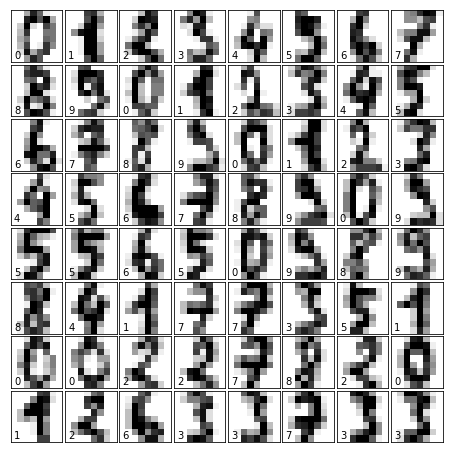

In [14]:
 from matplotlib import pyplot as plt
fig = plt.figure(figsize=(6, 6)) 
# figure size in inches 
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[]) 
    ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation='nearest') 
    # label the image with the target value
    ax.text(0, 7, str(digits.target[i]))

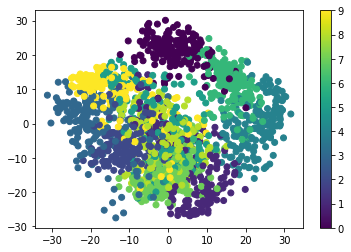

In [15]:
plt.figure()
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
proj = pca.fit_transform(digits.data) 
plt.scatter(proj[:, 0], proj[:, 1], c=digits.target) 
plt.colorbar()
plt.show()

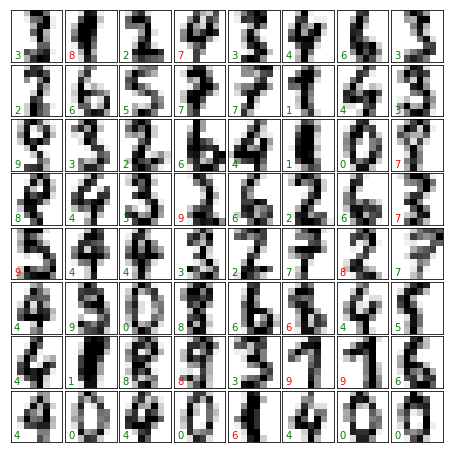

In [16]:
# Digit (multi-class) classification with LVQ
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
X = digits.data
y = digits.target

# split the data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,test_size=0.2)

scaler = MinMaxScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)

# train the model
#clf = GaussianNB()
clf = LVQ(n_components=5,epochs=10,alpha=0.5,
          random_state=1,initial_state='Normal')
clf.fit(X_train, y_train)

# use the model to predict the labels of the test data
predicted = clf.predict(X_test)
probability = clf.predict_proba(X_test)[:,0]
expected = y_test

# Plot the prediction
fig = plt.figure(figsize=(6, 6)) # figure size in inches 
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
# plot the digits: each image is 8x8 pixels
for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[]) 
    ax.imshow(X_test.reshape(-1, 8, 8)[i], cmap=plt.cm.binary,
              interpolation='nearest')
    # label the image with the target value
    if predicted[i] == expected[i]:
        ax.text(0, 7, str(predicted[i]), color='green')
    else:
        ax.text(0, 7, str(predicted[i]), color='red')

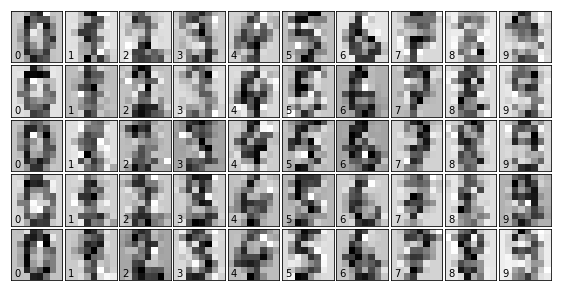

In [17]:
# LVQ prototype images
X_LVQ = clf.weights
y_LVQ = clf.label_weights
fig = plt.figure(figsize=(7.5, 15./4.)) # figure size in inches 
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(50):
    ax = fig.add_subplot(5, 10, i + 1, xticks=[], yticks=[]) 
    ax.imshow(X_LVQ.reshape(-1, 8, 8)[i], cmap=plt.cm.binary,
              interpolation='nearest')
    # label the image with the target value
    ax.text(0, 7, str(y_LVQ[i]))

In [18]:
matches = (predicted == expected) 
print(matches.sum())
print(len(matches))

299
360


In [19]:
matches.sum() / float(len(matches))

0.8305555555555556

In [20]:
from sklearn import metrics 
print(metrics.classification_report(expected, predicted))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        39
          1       0.94      0.50      0.65        34
          2       0.81      0.81      0.81        37
          3       0.79      0.86      0.83        44
          4       1.00      0.98      0.99        42
          5       0.97      0.83      0.89        35
          6       0.89      1.00      0.94        31
          7       0.73      0.97      0.83        31
          8       0.73      0.68      0.70        40
          9       0.50      0.63      0.56        27

avg / total       0.85      0.83      0.83       360



In [21]:
print(metrics.confusion_matrix(expected, predicted)) 
plt.show()

[[39  0  0  0  0  0  0  0  0  0]
 [ 0 17  6  0  0  0  3  0  5  3]
 [ 0  0 30  1  0  0  0  1  3  2]
 [ 0  0  0 38  0  0  0  4  0  2]
 [ 0  0  0  0 41  0  0  1  0  0]
 [ 0  0  0  1  0 29  0  1  0  4]
 [ 0  0  0  0  0  0 31  0  0  0]
 [ 0  0  0  0  0  0  0 30  1  0]
 [ 0  0  1  4  0  0  1  1 27  6]
 [ 0  1  0  4  0  1  0  3  1 17]]


In [22]:
from sklearn.neural_network import MLPClassifier

X = digits.data
y = digits.target

mlp = MLPClassifier(hidden_layer_sizes=(100), activation='logistic', 
                    max_iter = 200)
# Train the classifier with the traning data
mlp.fit(X_train,y_train)
print("Training set score: %f" % mlp.score(X_train, y_train))
print("Test set score: %f" % mlp.score(X_test, y_test))

Training set score: 0.983994
Test set score: 0.963889
